In [44]:
# 载入需要的R包
# Load the required packages
library(keras)
library(tensorflow)
library(ROCR) 
library(pROC)
library(ggplot2)
library(tidyverse)
library(ggsci)
library(cowplot)
library(reshape2)
library(patchwork)
library(yardstick)
library(caret)
library(randomForest)
library(e1071)
library(kernlab)
library(precrec)
library(ggbreak)
library(Biostrings)
library(readxl)

In [2]:
keras <- import("keras")

In [3]:
# 采用one-hot编码的方式对序列进行编码
# We adopted one-hot encoding method to convert each nucleotide sequence into a binary vector, 
# such as A (1, 0, 0, 0, 0), C (0, 1, 0, 0, 0), G (0, 0, 1, 0, 0), T (0, 0, 0, 1, 0), N (0, 0, 0, 0, 1). 
EncodingSeq <- function(sequence){
    A <- "10000"
    C <- "01000"
    G <- "00100"
    T <- "00010"
    N <- "00001"
    encoded_seq <- lapply(sequence,function(x){
        x <- toupper(x)
        x <- gsub("A",A,x)
        x <- gsub("C",C,x)
        x <- gsub("G",G,x)
        x <- gsub("T",T,x)
        x <- gsub("N",N,x)
    })
    encoded_seq <- unlist(encoded_seq)
    return(encoded_seq)
}

In [4]:
# 将one-hot编码的序列转换成3维矩阵
# Converting one-hot encoded sequence into 3D matrix
convStringToMatrix <- function(encodedSeqs, seq_len=100){
  # ensure the character type of encodedSeqs
  encodedSeqs <- as.character(encodedSeqs)
  # create the feature matrix:
  x_array <- array(data = 0, dim = c(5,seq_len, length(encodedSeqs)))
  s <- 1 # sequence/instance index
  r <- 1 # row of the matrix, each row represents A,T/U, G, C
  c <- 1 # column of the matrix, each column represents each nucleotide in the 100nt sequence
  j <- 1 # index of character in the one-hot encoded string
  # store each character into the right place of 3D matrix
  while (s <= length(encodedSeqs)) {
    c <- 1
    while (c <= seq_len) {
      r <- 1
      while (r <= 5) {
        x_array[r,c,s] <- as.integer(substr(encodedSeqs[s], j,j))
        r <- r + 1
        j <- j + 1
      }
      c <- c + 1
    }
    s <- s + 1
    j <- 1
  }

  #change the index order of x_array to the one keras package required:
  x_array_new <- aperm(x_array,c(3,2,1))
  return(x_array_new)
}

In [5]:
# 构建CNN训练模型
# Model architecture
train_model <- function(x_train, y_train, flank_len){
    tf$random$set_seed(123)
    set.seed(123)
    set_random_seed(123)
    model <- keras_model_sequential()
    model %>%
        layer_conv_1d(filters = 128, kernel_size = 12, strides = 1,padding = "valid",input_shape = c(flank_len*2,5), activation = "relu") %>%
        layer_dropout(0)%>%
        layer_conv_1d(filters = 128, kernel_size = 6, strides = 1,activation = 'relu') %>%
        layer_dropout(0.5) %>%
        layer_max_pooling_1d(pool_size =5, strides =4)%>%
        layer_dropout(0.5)%>%
        layer_flatten() %>%
        layer_dense(units = 2, activation = "softmax")
    model %>% compile(
        loss = "binary_crossentropy",
        optimizer = optimizer_rmsprop(),
        metrics = c("accuracy")
      )
    model %>% 
       fit(
         x = x_train, y =y_train,
         epochs = 50,
         validation_split = 0.1,
         verbose = 2
       )
    return(model)
}

In [6]:
# 按照正负样本集的比例进行模型训练选择
# the ratio of the positive and negative instances was set as 1∶1, 1∶2, 1∶3, 1∶4 and 1∶5, respectively
Ratio <- c("1:1","1:2","1:3","1:4","1:5")

## The performance of PlantC2U in independent test based on the different flanking sequence and the ratio of positive and negative instances from clusters.

In [7]:
#write.csv(performance,"../Tables/model_performance_clusters.csv",row.names=F)

# Figure S1A

In [8]:
performance <- read.csv("../Tables/model_performance_clusters.csv")

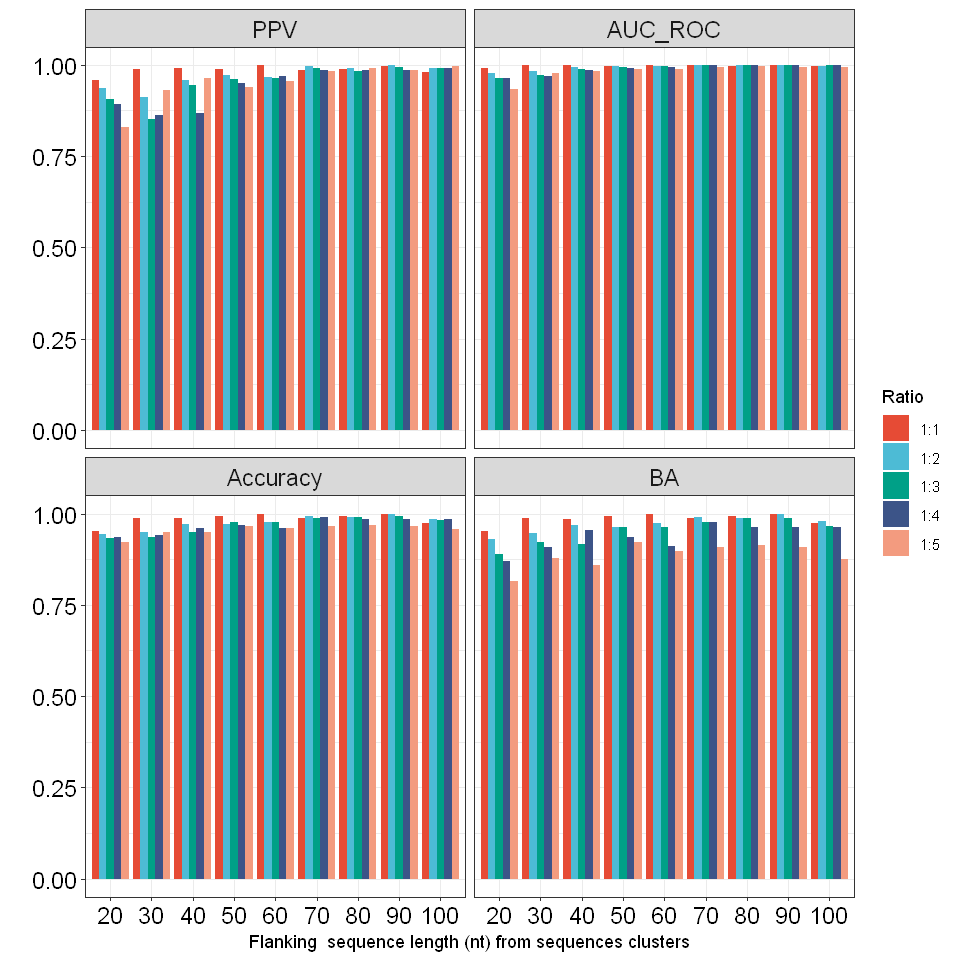

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
FigureS1A <- performance %>%
    dplyr::select(flank_len, Ratio=Ratio.ratio.,PPV,AUC_ROC,Accuracy,BA) %>%
    melt(.,id=c('flank_len','Ratio')) %>%
    mutate(flank_len=factor(flank_len)) %>%
    ggplot(aes(flank_len,value,fill=Ratio))+
        geom_bar(stat='identity',position = position_dodge())+
        theme_bw()+
        #scale_y_break(c(0.1,0.7))+
        facet_wrap(~variable)+
        theme(axis.text = element_text(size=14,color='black'),
             legend.position='right',
             strip.text = element_text(size = 14))+
        scale_fill_npg()+
        ylim(0,1)+
        xlab("Flanking  sequence length (nt) from sequences clusters")+ylab("")
FigureS1A

### The performance of PlantC2U in independent test based on the different flanking sequence and the ratio of positive and negative instances from primary negative samples.

In [10]:
# write.csv(performance2,"../Tables/model_performance_primary_negative_samples.csv",row.names=F)

# Figure S1B

In [11]:
performance2 <- read.csv("../Tables/model_performance_primary_negative_samples.csv")

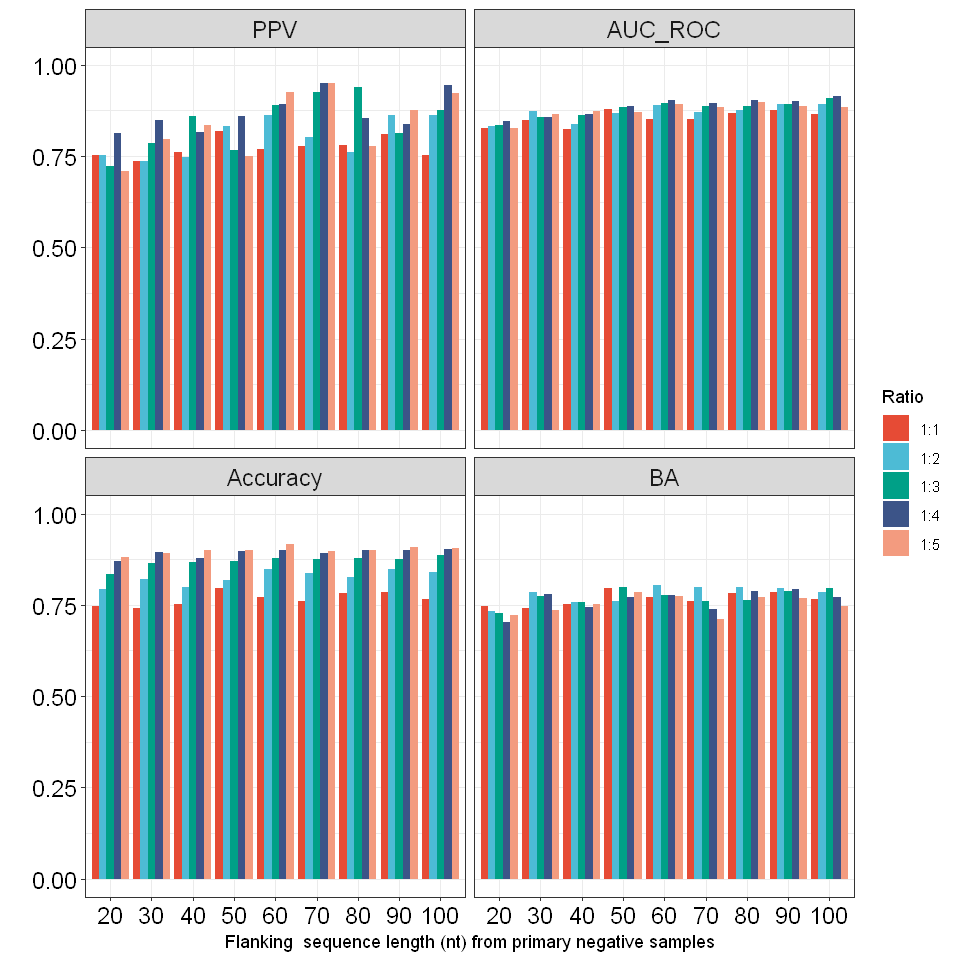

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
FigureS1B <- performance2 %>%
    dplyr::select(flank_len, Ratio=Ratio.ratio.,PPV,AUC_ROC,Accuracy,BA) %>%
    melt(.,id=c('flank_len','Ratio')) %>%
    mutate(flank_len=factor(flank_len)) %>%
    ggplot(aes(flank_len,value,fill=Ratio))+
        geom_bar(stat='identity',position = position_dodge())+
        theme_bw()+
        facet_wrap(~variable)+
        theme(axis.text = element_text(size=14,color='black'),
             legend.position='right',
             strip.text = element_text(size = 14))+
        scale_fill_npg()+
        xlab("Flanking  sequence length (nt) from primary negative samples")+ylab("")+
        ylim(0,1)#+
        #scale_y_break(c(0.1,0.7))
FigureS1B 

In [13]:
Figure2B <- performance2 %>%
               dplyr::select(flank_len, Ratio=Ratio.ratio.,MCC) %>% 
                mutate(Samples="The primary negative samples")

In [14]:
Figure2A <- performance %>%
               dplyr::select(flank_len, Ratio=Ratio.ratio.,MCC) %>% 
                mutate(Samples="The sequences clusters")

In [15]:
figure2A2B <- rbind(Figure2B,Figure2A)

# Figure2A 2B

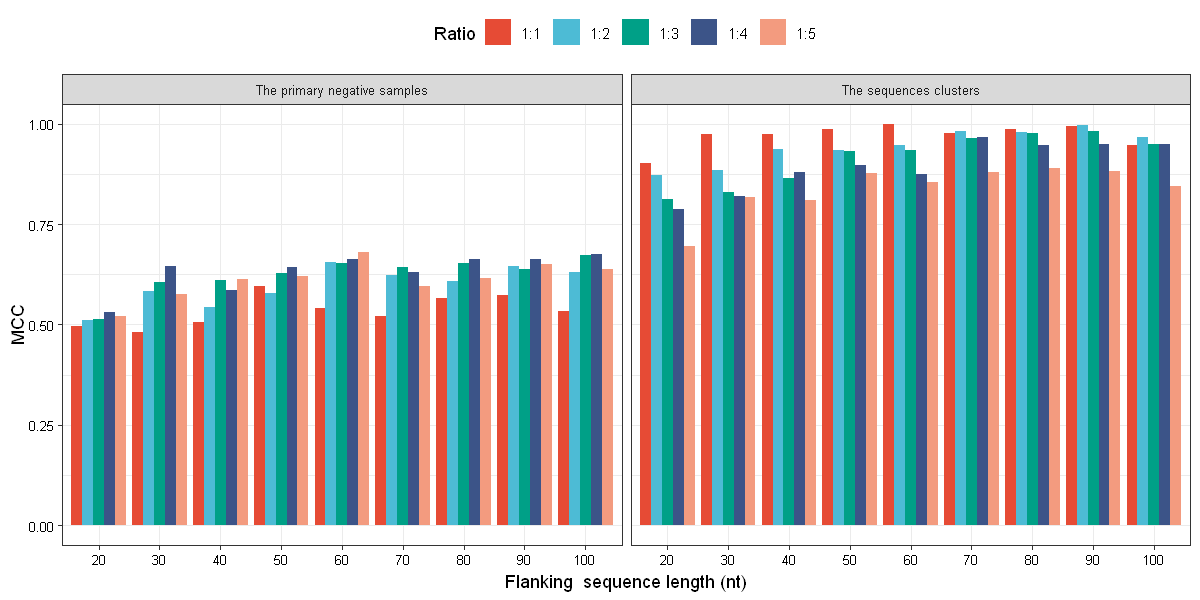

In [16]:
options(repr.plot.width=10, repr.plot.height=5)
Figure2A2B <- figure2A2B %>%
    mutate(flank_len=factor(flank_len)) %>%
    ggplot(aes(flank_len,MCC,fill=Ratio))+
        geom_bar(stat='identity',position = position_dodge())+
        theme_bw()+
        theme(axis.text = element_text(size=8,color='black'),
             legend.position='top',
             strip.text = element_text(size = 8))+
        scale_fill_npg()+
        xlab("Flanking  sequence length (nt)")+
    facet_grid(~Samples)
Figure2A2B

# PREPACT

In [17]:
# In this study, we concluded that the 90-nt flanking sequence in combination with the 1:1 ratio of positive and negative instances 
# from sequence clusters would make the model perform better than other combinations
flank_len <- 90
load("../model/Choose_flank_90_ratio_1.RData")
x_train <- convStringToMatrix(train$encoded_seq,seq_len=flank_len*2) 
x_test <- convStringToMatrix(test$encoded_seq,seq_len=flank_len*2)
y_train <- to_categorical(train$label,2) 
y_test <- to_categorical(test$label,2)
model <- keras$models$load_model("../model/Choose_flank_90_ratio_1.hdf5")
cnn_pred <- model$predict(x_test)

In [18]:
# in this study, we applied PREPACT tool to predict C-to-U RNA editing sites by using the public web service of PREPACT, 
# and then evaluated its performance based on the same testing dataset as PlantC2U
test_data <- lapply(rownames(test),function(name){
    x <- unlist(str_split(name,"_"))
    if(length(x)==6){
        re <- data.frame(genbank=x[3],Org=x[4],gene=x[5],pos=x[6],name)
    }else{
        genbank <- paste0(x[3],"_",x[4])
        re <- data.frame(genbank,Org=x[5],gene=x[6],pos=x[7],name)
    }
    return(re)
})
test_data <- do.call('rbind',test_data)

In [19]:
prepact <- readLines("../REDIdb/test_Genbank.csv")

In [20]:
prepact2 <- lapply(prepact,function(x){
    x <- unlist(str_split(x,","))
    x2 <- unique(x[-c(1:2)])
    if(x[2]=="pseudo-rbcL"){
        x[2] <- "rbcL"
        x2 <- x2[grepl(x[2],x2)]
        x2 <- gsub(x[2],"",x2)
        pos <- str_extract(x2,"\\d+")
        pos <- unique(pos)
    }else if(x[2]=="ycf10" | x[2]=="cemA"){
        x2 <- x2[grep("ycf10|cemA",x2)]
        x2 <- gsub("ycf10","",x2)
        x2 <- gsub("cemA","",x2)
        pos <- str_extract(x2,"\\d+")
        pos <- unique(pos)
    }else{
        x2 <- x2[grepl(x[2],x2)]
        x2 <- gsub(x[2],"",x2)
        pos <- str_extract(x2,"\\d+")
        pos <- unique(pos)        
    }
    re <- data.frame(genbank=x[1],gene=x[2],pos,percentage=x[length(x)])
    return(re)
})

In [21]:
prepact2 <- do.call('rbind',prepact2)

In [22]:
reference <- readLines("../REDIdb/test_Genbank_reference.csv")

In [23]:
reference <- lapply(reference,function(x){
    x <- unlist(str_split(x,","))
    re <- data.frame(genbank=x[1],gene=x[2],reference=paste(x[-c(1:2)],collapse =","))
    return(re)
})

In [24]:
reference <- do.call("rbind",reference)

In [25]:
PREPACT <- test_data %>%
    left_join(prepact2) %>%
    left_join(reference) %>%
    mutate(percentage=ifelse(is.na(percentage),0,as.numeric(percentage)))

Joining with `by = join_by(genbank, gene, pos)`
Joining with `by = join_by(genbank, gene)`


In [26]:
dim(PREPACT)

[1] 791   7

In [27]:
## We used the caret R package to implement randomForest and e1071 R packages for RF and SVM model 
## training with 10-fold cross-validation, respectively.
flank_len <- 90
ratio <- 1
Positive <- readBStringSet(paste0("../model/Choose_flank_",flank_len,"_positive_seq.fasta")) 
Positive <- data.frame(Positive)
Negative <- readBStringSet(paste0("../model/Choose_flank_",flank_len,"_negative_seq_",ratio,".fasta")) 
Negative <- data.frame(Negative)
label <- c(rep(1,nrow(Positive)),rep(0,nrow(Negative)))
data <- data.frame(label,RNA_input_seq=c(Positive$Positive,Negative$Negative))
data$encoded_seq <- EncodingSeq(data$RNA_input_seq)

In [28]:
feature <- lapply(data$encoded_seq,function(x){
    x <- as.numeric(unlist(str_split(x,"")))
    x <- t(data.frame(feature=x))
    x <- data.frame(x)
})

In [29]:
feature <- do.call('rbind',feature)

In [30]:
feature$label <- factor(data$label)

In [31]:
set.seed(123)
inx <- sample(1:nrow(feature),0.75*nrow(feature))
train <- feature[inx,]
test <- feature[-inx,]

# randomForest

In [32]:
# We used the caret R package to implement randomForest R package for model training with 10-fold cross-validation
ctrl <- trainControl(method = "cv",
                     number=10)
set.seed(123)
rf <- train(label ~ ., data = train,
             method = "rf",
             ntree = 100,
             trControl = ctrl,
             tuneGrid = data.frame(mtry = 30))

In [33]:
rf_pred <- predict(rf,test,type="prob")

# SVM

In [34]:
# We used the caret R package to implement e1071 R packages for SVM model training with 10-fold cross-validation
svm_model <- train(label ~ ., data = train,
             method = "svmLinear",
             trControl = ctrl)

In [35]:
svm_pred <- predict(svm_model,test)

In [36]:
result <- data.frame(label=test$label, CNN=cnn_pred[,2], rf= rf_pred[,2], svm =  as.numeric(svm_pred)-1,PREPACT=PREPACT$percentage)

In [37]:
Model <- c('CNN','Random Forest','SVM','PREPACT')
roclist <- lapply(2:5,function(i){
    roclist <- roc(result$label, result[,i])
    print(roclist)
})
names(roclist) <- Model

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = result$label, predictor = result[, i])

Data: result[, i] in 399 controls (result$label 0) < 392 cases (result$label 1).
Area under the curve: 0.9991


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = result$label, predictor = result[, i])

Data: result[, i] in 399 controls (result$label 0) < 392 cases (result$label 1).
Area under the curve: 0.9871


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = result$label, predictor = result[, i])

Data: result[, i] in 399 controls (result$label 0) < 392 cases (result$label 1).
Area under the curve: 0.8964


Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = result$label, predictor = result[, i])

Data: result[, i] in 399 controls (result$label 0) < 392 cases (result$label 1).
Area under the curve: 0.9137


In [38]:
mycolor <- c("#20ACBD", "#cc8e12", "#d561dd",'red')

# Figure2C

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


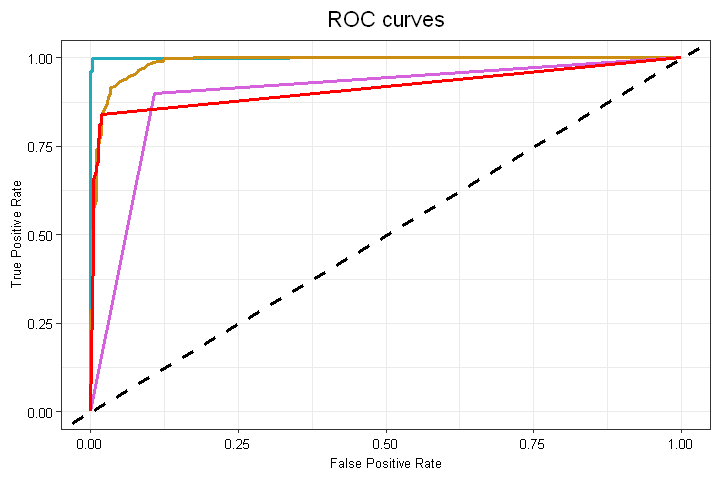

In [39]:
options(repr.plot.width=6, repr.plot.height=4)
Figure2C <- ggroc(roclist,legacy.axes=T,size=1)+
    theme_bw()+
    theme(axis.title=element_text(size=8),
            axis.text=element_text(size=8,color='black'),
            legend.position="none",
             plot.title = element_text(hjust = 0.5))+
    xlab("False Positive Rate")+ylab("True Positive Rate")+
    ggtitle("ROC curves")+
    geom_abline(intercept = 0, slope = 1,linetype="dashed",size=1)+
    scale_color_manual(values=mycolor)+
guides(color=guide_legend(title = "Model"))
Figure2C

In [40]:
SRRs <- lapply(2:5,function(i){
    print(Model[i-1])
    re <- data.frame(V1=result$label, V2=result[,i])
    re$V1 <- factor(re$V1)
    # Calculate ROC and Precision-Recall curves
    re <- evalmod(scores = re$V2, labels = re$V1)
    aucs <- auc(re)
    aucs_prc <- subset(aucs, curvetypes == "PRC")
    print(aucs)
    re <- re %>%
    as.data.frame() %>%
    mutate(Model=Model[i-1])
    return(re)
})
SRRs <- do.call("rbind",SRRs)

[1] "CNN"
  modnames dsids curvetypes      aucs
1       m1     1        ROC 0.9990538
2       m1     1        PRC 0.9992567
[1] "Random Forest"
  modnames dsids curvetypes      aucs
1       m1     1        ROC 0.9870851
2       m1     1        PRC 0.9846268
[1] "SVM"
  modnames dsids curvetypes      aucs
1       m1     1        ROC 0.8963704
2       m1     1        PRC 0.8672532
[1] "PREPACT"
  modnames dsids curvetypes      aucs
1       m1     1        ROC 0.9137224
2       m1     1        PRC 0.9369761


# Figure2D

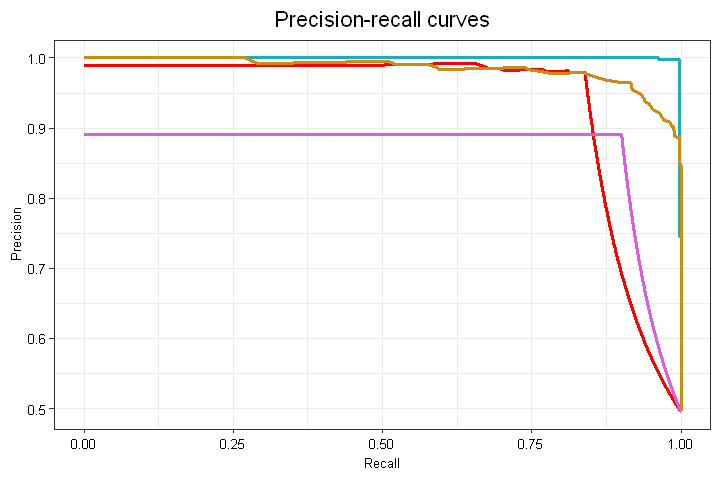

In [41]:
Figure2D <- SRRs %>%
    as.data.frame() %>%
    filter(type=="PRC") %>%
    ggplot(aes(x,y,color=Model))+
        geom_line(size=1)+
    theme_bw()+
    theme(axis.title=element_text(size=8),
            axis.text=element_text(size=8,color='black'),
            legend.position="none",
             plot.title = element_text(hjust = 0.5))+
    xlab("Recall")+ylab("Precision")+
    ggtitle("Precision-recall curves")+
scale_color_manual(values=c("#20ACBD",'red' ,"#cc8e12","#d561dd"))
Figure2D

# Figure2

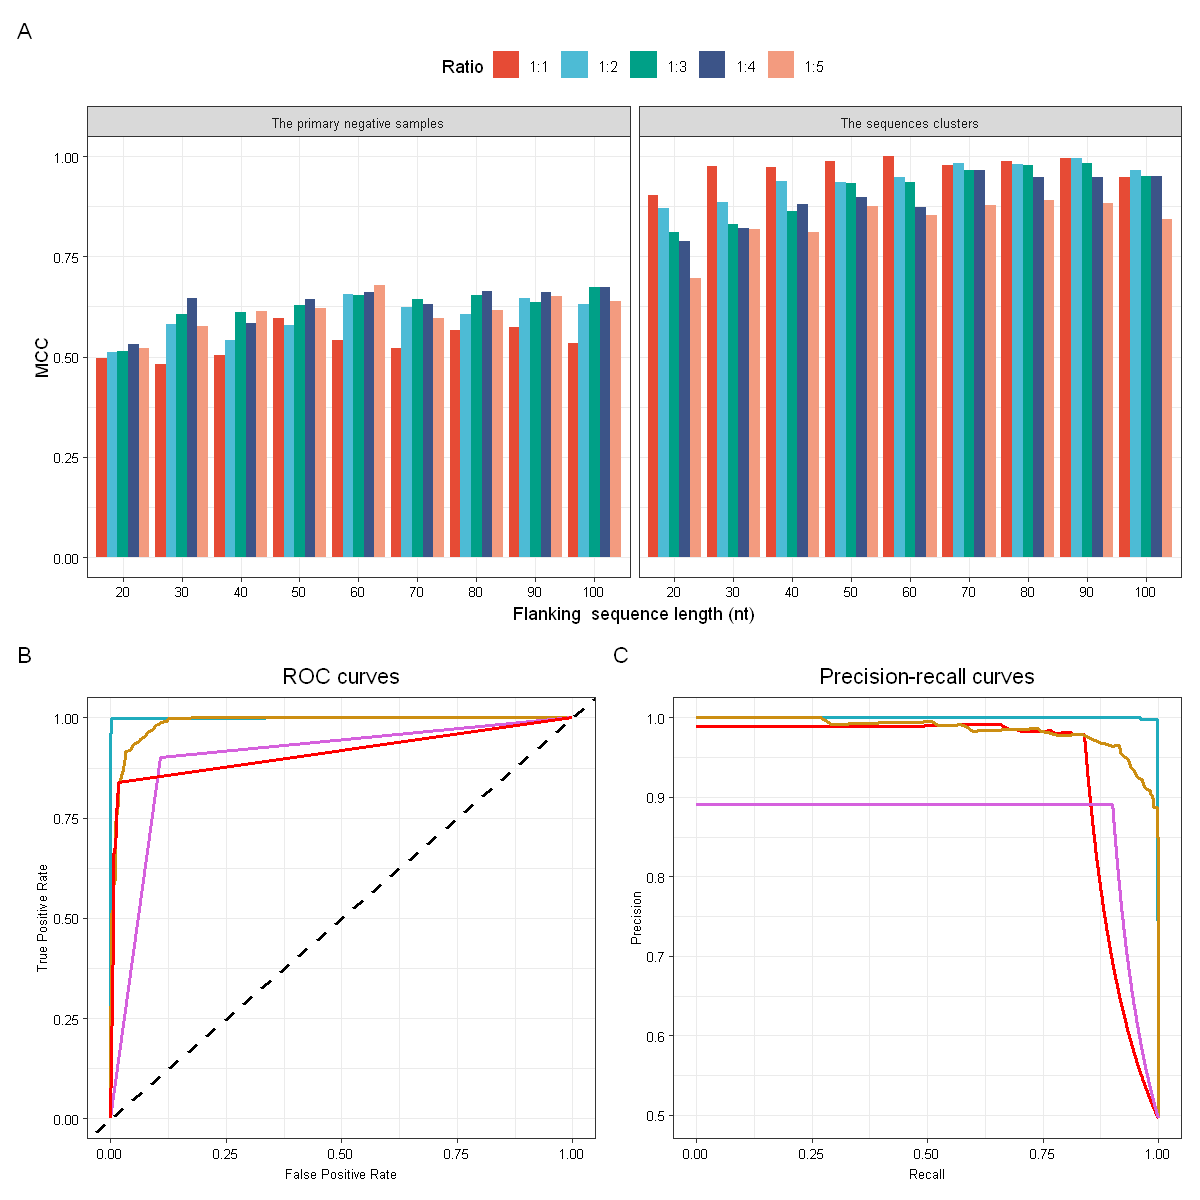

In [42]:
options(repr.plot.width=10, repr.plot.height=10)
Figure2 <- Figure2A2B/(Figure2C+Figure2D)+plot_annotation(tag_levels = 'A')
Figure2

# R Session Information

In [43]:
utils::sessionInfo()

R version 4.3.1 (2023-06-16 ucrt)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19044)

Matrix products: default


locale:
[1] LC_COLLATE=Chinese (Simplified)_China.utf8 
[2] LC_CTYPE=Chinese (Simplified)_China.utf8   
[3] LC_MONETARY=Chinese (Simplified)_China.utf8
[4] LC_NUMERIC=C                               
[5] LC_TIME=Chinese (Simplified)_China.utf8    

time zone: Asia/Shanghai
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] readxl_1.4.3         Biostrings_2.68.1    GenomeInfoDb_1.36.1 
 [4] XVector_0.40.0       IRanges_2.34.1       S4Vectors_0.38.1    
 [7] BiocGenerics_0.46.0  ggbreak_0.1.2        precrec_0.14.2      
[10] kernlab_0.9-32       e1071_1.7-13         randomForest_4.7-1.1
[13] caret_6.0-94         lattice_0.21-8       yardstick_1.2.0     
[16] patchwork_1.1.2      reshape2_1.4.4       cowplot_1.1.1       
[19] gg